In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install -U bitsandbytes

In [3]:
import json
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset

import torch
import re
from transformers import AutoTokenizer, AutoModelForCausalLM
import nltk
import uuid
import json
import torch
import numpy as np
import pandas as pd
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch.nn.functional as F

In [4]:
# !pip install -U bitsandbytes

In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Llama-8B")
model = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)
model.eval()



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear8bitLt(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): Lla

In [108]:
from backtracking_data_sampling import *

In [109]:
# # Define CoT cues
# COT_CUES = {
#     "is_backtracking": [" Wait", " No", " Nope", " Actually", " Hold", " Hang", " Oops", " Sorry"],
# }

# # Load OpenR1-Math-220k Dataset
# dataset = load_dataset("open-r1/OpenR1-Math-220k", split="train")

# # Convert dataset to Pandas DataFrame
# df = dataset.to_pandas()
# df["cot_cue_key"], df["cot_cue_value"] = zip(*df["messages"].map(find_cot_cue))

# df_filtered = df.dropna(subset=["cot_cue_key", "cot_cue_value"], how="all")

# # Assuming df["messages"] is a list of lists where each sublist contains multiple message exchanges
# df_filtered["message_pairs"] = df_filtered["messages"].apply(split_messages_into_pairs)

# # Explode the DataFrame so each row contains exactly one (user, assistant) pair
# df_exploded = df_filtered.explode("message_pairs", ignore_index=True)
# len(df_exploded)

# # Display a sample of processed data
# df_exploded[["solution", "cot_cue_key", "cot_cue_value"]].head(10)
# df_exploded["prefill"] = df_exploded.apply(generate_prefill, axis=1)

In [8]:
# df_exploded.to_pickle("openr1_math_with_cot_cues.pkl")


In [9]:
df_exploded = pd.read_pickle("openr1_math_with_cot_cues.pkl")

In [10]:
df_exploded

problem  \
0      ## Task B-1.3.\n\nA ship traveling along a riv...   
1      3. (6 points) A construction company was build...   
2      Prove that number $1$ can be represented as a ...   
3      4. Given the three sides of an obtuse triangle...   
4      1. Solve the equation: $\frac{8 x+13}{3}=\frac...   
...                                                  ...   
92114  6) What is the value of the square of the squa...   
92115  385. $(\tan \alpha+\cot \alpha)^{2}-(\tan \alp...   
92116  In a communication system consisting of 2001 s...   
92117  Let $n$ be a positive integer such that $1 \le...   
92118  10. Given that\n$$\n\begin{aligned}\n\alpha+\b...   

                                                solution  \
0      ## Solution.\n\nLet $t$ be the time required f...   
1      3. (6 points) A construction company builds a ...   
2      1. **Restate the problem in a more manageable ...   
3                                                    $D$   
4      1. $\frac{8 x+13}{3}=\frac{19-12 x}{2}-\left(1...   
...                                                  ...   
92114  6) The answer is $(\mathbf{D})$.\n\nIndeed, $\...   
92115  Solution. We will use the formulas for the squ...   
92116  Calculate the number of pairs of connected sub...   
92117  1. We need to determine the number of integers...   
92118  10. Answer. 8\nSolution. We consider the polyn...   

                                                  answer   problem_type  \
0      v_{R}=4\mathrm{~}/\mathrm{},v_{B}=10\mathrm{~}...        Algebra   
1                                                    180        Algebra   
2                                                     8   Number Theory   
3                                                      D       Geometry   
4                                            \frac{1}{4}        Algebra   
...                                                  ...            ...   
92114                                              8^{8}        Algebra   
92115                                                  4        Algebra   
92116                            n=2tfor=0,1,\ldots,1000  Combinatorics   
92117                                                 22  Number Theory   
92118                                                  8        Algebra   

           question_type      source                                  uuid  \
0      math-word-problem   olympiads  586fd646-76d6-5070-8c81-9993ab9d8559   
1      math-word-problem   olympiads  1d57f4b3-c516-5522-91cc-a60dd91f6f66   
2      math-word-problem  aops_forum  1cd82e3d-2e7a-5eca-9571-62f5669824c4   
3                    MCQ  cn_contest  ea24dff6-9e4d-5c55-9ec0-c4d55424997a   
4      math-word-problem   olympiads  a583d65c-9b4c-56ce-8263-47edbc22baa3   
...                  ...         ...                                   ...   
92114                MCQ   olympiads  796f884e-f556-5fdd-87b1-5696a4a3e2ce   
92115  math-word-problem   olympiads  9d47d075-9010-5c24-8f95-cb080d5c4e52   
92116  math-word-problem   olympiads  2e8d3afa-4595-5cf2-a5c8-3f6537d72ed0   
92117  math-word-problem  aops_forum  920052fd-d9f6-57fb-9b8b-512c39f399bb   
92118  math-word-problem   olympiads  d537c055-8730-5a6e-a7fc-046e9f1f45e4   

      is_reasoning_complete  \
0              [True, True]   
1              [True, True]   
2             [True, False]   
3              [True, True]   
4              [True, True]   
...                     ...   
92114          [True, True]   
92115          [True, True]   
92116                [True]   
92117          [True, True]   
92118          [True, True]   

                                             generations  \
0      [<think>\nOkay, so I need to find the speed of...   
1      [<think>\nOkay, let me try to figure out this ...   
2      [<think>\nOkay, so the problem is to prove tha...   
3      [<think>\nOkay, so I have this problem here wh...   
4      [<think>\nOkay, so I need to solve this equati...   
...                                 

In [39]:
df_exploded

problem  \
0      ## Task B-1.3.\n\nA ship traveling along a riv...   
1      3. (6 points) A construction company was build...   
2      Prove that number $1$ can be represented as a ...   
3      4. Given the three sides of an obtuse triangle...   
4      1. Solve the equation: $\frac{8 x+13}{3}=\frac...   
...                                                  ...   
92114  6) What is the value of the square of the squa...   
92115  385. $(\tan \alpha+\cot \alpha)^{2}-(\tan \alp...   
92116  In a communication system consisting of 2001 s...   
92117  Let $n$ be a positive integer such that $1 \le...   
92118  10. Given that\n$$\n\begin{aligned}\n\alpha+\b...   

                                                solution  \
0      ## Solution.\n\nLet $t$ be the time required f...   
1      3. (6 points) A construction company builds a ...   
2      1. **Restate the problem in a more manageable ...   
3                                                    $D$   
4      1. $\frac{8 x+13}{3}=\frac{19-12 x}{2}-\left(1...   
...                                                  ...   
92114  6) The answer is $(\mathbf{D})$.\n\nIndeed, $\...   
92115  Solution. We will use the formulas for the squ...   
92116  Calculate the number of pairs of connected sub...   
92117  1. We need to determine the number of integers...   
92118  10. Answer. 8\nSolution. We consider the polyn...   

                                                  answer   problem_type  \
0      v_{R}=4\mathrm{~}/\mathrm{},v_{B}=10\mathrm{~}...        Algebra   
1                                                    180        Algebra   
2                                                     8   Number Theory   
3                                                      D       Geometry   
4                                            \frac{1}{4}        Algebra   
...                                                  ...            ...   
92114                                              8^{8}        Algebra   
92115                                                  4        Algebra   
92116                            n=2tfor=0,1,\ldots,1000  Combinatorics   
92117                                                 22  Number Theory   
92118                                                  8        Algebra   

           question_type      source                                  uuid  \
0      math-word-problem   olympiads  586fd646-76d6-5070-8c81-9993ab9d8559   
1      math-word-problem   olympiads  1d57f4b3-c516-5522-91cc-a60dd91f6f66   
2      math-word-problem  aops_forum  1cd82e3d-2e7a-5eca-9571-62f5669824c4   
3                    MCQ  cn_contest  ea24dff6-9e4d-5c55-9ec0-c4d55424997a   
4      math-word-problem   olympiads  a583d65c-9b4c-56ce-8263-47edbc22baa3   
...                  ...         ...                                   ...   
92114                MCQ   olympiads  796f884e-f556-5fdd-87b1-5696a4a3e2ce   
92115  math-word-problem   olympiads  9d47d075-9010-5c24-8f95-cb080d5c4e52   
92116  math-word-problem   olympiads  2e8d3afa-4595-5cf2-a5c8-3f6537d72ed0   
92117  math-word-problem  aops_forum  920052fd-d9f6-57fb-9b8b-512c39f399bb   
92118  math-word-problem   olympiads  d537c055-8730-5a6e-a7fc-046e9f1f45e4   

      is_reasoning_complete  \
0              [True, True]   
1              [True, True]   
2             [True, False]   
3              [True, True]   
4              [True, True]   
...                     ...   
92114          [True, True]   
92115          [True, True]   
92116                [True]   
92117          [True, True]   
92118          [True, True]   

                                             generations  \
0      [<think>\nOkay, so I need to find the speed of...   
1      [<think>\nOkay, let me try to figure out this ...   
2      [<think>\nOkay, so the problem is to prove tha...   
3      [<think>\nOkay, so I have this problem here wh...   
4      [<think>\nOkay, so I need to solve this equati...   
...                                 

In [40]:
df_exploded["uuid"][1]

'1d57f4b3-c516-5522-91cc-a60dd91f6f66'

In [70]:
print(df_exploded["cot_cue_value"].value_counts())  # Verify count per category


cot_cue_value
Wait        86849
No           5043
Hold          148
Actually       76
Sorry           2
Hang            1
Name: count, dtype: int64


In [71]:
N = 100  # Number of rows to sample per unique cot_cue_value

df_sampled = df_exploded.groupby("cot_cue_value", group_keys=False).apply(lambda x: x.sample(min(len(x), N)))
df_sampled = df_sampled.reset_index(drop=True)

print(df_sampled["cot_cue_value"].value_counts())  # Verify sample distribution


cot_cue_value
Hold        100
No          100
Wait        100
Actually     76
Sorry         2
Hang          1
Name: count, dtype: int64


/tmp/ipykernel_365083/1408063390.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_exploded.groupby("cot_cue_value", group_keys=False).apply(lambda x: x.sample(min(len(x), N)))


In [111]:
from backtracking_data_sampling import *

# examples = backtracking_samples
STEP_BY_STEP_SUFFIX = (
    "\nPlease reason step by step, and put your final answer within \\boxed{}.\n"
)
activations_data = []
count = 0
# Iterate over each row in the DataFrame
for index, row in df_sampled.iterrows():
    # if row["uuid"] == '1d57f4b3-c516-5522-91cc-a60dd91f6f66':
    activations_data.extend(process_samples(row, tokenizer, model))
    count += 1
    # if count > 1000:
    #     break

 Actually
cue_char_indices []
Total layers in hidden_states: 32
Extracted layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Activation shape for first layer: (938, 4096)
 Actually
cue_char_indices []
Total layers in hidden_states: 32
Extracted layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Activation shape for first layer: (2381, 4096)
 Actually
cue_char_indices []
Total layers in hidden_states: 32
Extracted layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Activation shape for first layer: (1293, 4096)
 Actually
cue_char_indices []
Total layers in hidden_states: 32
Extracted layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Activation shape for first layer: (979, 4096)
 Actually


In [112]:
import pickle


# mean of all the examples, subtracted the mean of all the non examples --> steering vector
# forward hook on the model, at the output of that layer, added the steering vector. 
# Save to Pickle
# with open("activations_data_sampled.pkl", "wb") as f:
#     pickle.dump(activations_data, f)

# print("Saved as Pickle successfully!")

# Load back from Pickle
with open("activations_data_ex.pkl", "rb") as f:
    activations_data = pickle.load(f)

print(f"Loaded {len(activations_data)} entries from Pickle")

Loaded 43981 entries from Pickle


In [113]:
activations_data[0].keys()

dict_keys(['uuid', 'full_message', 'sentence', 'top_tokens', 'char_offset', 'determining_token_index', 'cue_start', 'sentence_start', 'sentence_start_index', 'activations', 'cot_cue_value'])

In [114]:
activations_data[0]["top_tokens"]

torch.return_types.topk(
values=tensor([0.3979, 0.3569, 0.2130, 0.0147, 0.0084], device='cuda:0',
       dtype=torch.float16),
indices=tensor([89290,  6914,   578, 11995,   473], device='cuda:0'))

In [115]:
activations_data[0]["cot_cue_value"]

' No'

In [116]:
# cue_start
# if cue_start == determining_token_index and 

In [127]:
def collect_relevant_activations(activations_data, tokenizer):
    """
    Collects activations from each layer for backtracking and non-backtracking sentences.
    
    Returns:
        activations_dict = {
            "backtracking": [{layer_1: activations, layer_2: activations, ...}],
            "non_backtracking": [{layer_1: activations, layer_2: activations, ...}]
        }
    """
    activations_dict = {"backtracking": {}, "non_backtracking": {}}
    max_non = 500
    count = 0
    for data in activations_data:
        cue_start = data["cue_start"]
        determining_token_index = data["determining_token_index"]
        cot_cue_value = data["cot_cue_value"]
        top_tokens = data["top_tokens"]
        activations = data["activations"]
        sentence_start = data["sentence_start"]

        # Tokenize the CoT cue value and get its token ID
        cot_cue_token_id = tokenizer(cot_cue_value, add_special_tokens=False)["input_ids"][0]
        # print(cue_start)
        # Extract top token indices and probabilities
        top_token_ids = top_tokens.indices.tolist()
        top_probs = top_tokens.values.tolist()

        # Check if the sentence starts with the cue and token is in top predictions [[start, end]]
        if cue_start and cue_start[0][0] == determining_token_index and cot_cue_token_id in top_token_ids:
            cue_index = top_token_ids.index(cot_cue_token_id)  # Get index in top predictions
            cue_probability = top_probs[cue_index]  # Get probability

            # print(cue_probability,  top_token_ids[cue_index]) 
            # Collect activations for all layers
            layer_activations = {layer: activations[layer][1] for layer in activations}  # Activation at token index 1

            if cue_probability > 0.5:  # High confidence in cue prediction
                # print(cue_probability,  top_token_ids[cue_index]) 
                for layer, activation in activations.items():
                    if layer not in activations_dict["backtracking"]:
                        activations_dict["backtracking"][layer] = []
                    activations_dict["backtracking"][layer].append(activation[0])  # Activation of wait at token index 1, of preceding wait is at  0 

        else:
            if cot_cue_token_id not in top_token_ids or top_probs[ top_token_ids.index(cot_cue_token_id)] < .05:
                print(top_token_ids, top_probs) 
                count += 1
                if count > max_non:
                    continue
                for layer, activation in activations.items():
                    # print("layer", layer)
                    if layer not in activations_dict["non_backtracking"]:
                        activations_dict["non_backtracking"][layer] = []
                    activations_dict["non_backtracking"][layer].append(activation[0])  # Activation at token index 1

    return activations_dict

# Example usage

"""
relevant_activations = {
    "backtracking": {layer_1: [activation_1, activation_2, ...], ...},
    "non_backtracking": {layer_1: [activation_1, activation_2, ...], ...},
    "other_class_1": {layer_1: [activation_1, activation_2, ...], ...},
    "other_class_2": {layer_1: [activation_1, activation_2, ...], ...}
}

"""
relevant_activations = collect_relevant_activations(activations_data, tokenizer)


[89290, 6914, 578, 11995, 473] [0.39794921875, 0.35693359375, 0.2130126953125, 0.0147247314453125, 0.008392333984375]
[82671, 3277, 35339, 1628, 1952] [0.79638671875, 0.1695556640625, 0.0208892822265625, 0.00926971435546875, 0.0010404586791992188]
[10267, 22818, 791, 40, 4516] [0.92333984375, 0.023101806640625, 0.016387939453125, 0.0151519775390625, 0.00738525390625]
[4815, 2100, 5112, 3011, 4314] [0.487548828125, 0.230224609375, 0.07476806640625, 0.07135009765625, 0.03759765625]
[791, 7184, 3915, 22818, 23274] [0.689453125, 0.17431640625, 0.077392578125, 0.0149993896484375, 0.00909423828125]
[1187, 3146, 16, 578, 966] [0.99951171875, 0.0003800392150878906, 2.8371810913085938e-05, 1.2695789337158203e-05, 2.4437904357910156e-06]
[17, 14524, 256, 5996, 2355] [0.9951171875, 0.0028839111328125, 0.0010280609130859375, 0.0010118484497070312, 2.8252601623535156e-05]
[966, 868, 1187, 1691, 1591] [0.96142578125, 0.0229644775390625, 0.0150604248046875, 0.0003981590270996094, 0.000167250633239746

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [129]:
len(relevant_activations["non_backtracking"][0])

500

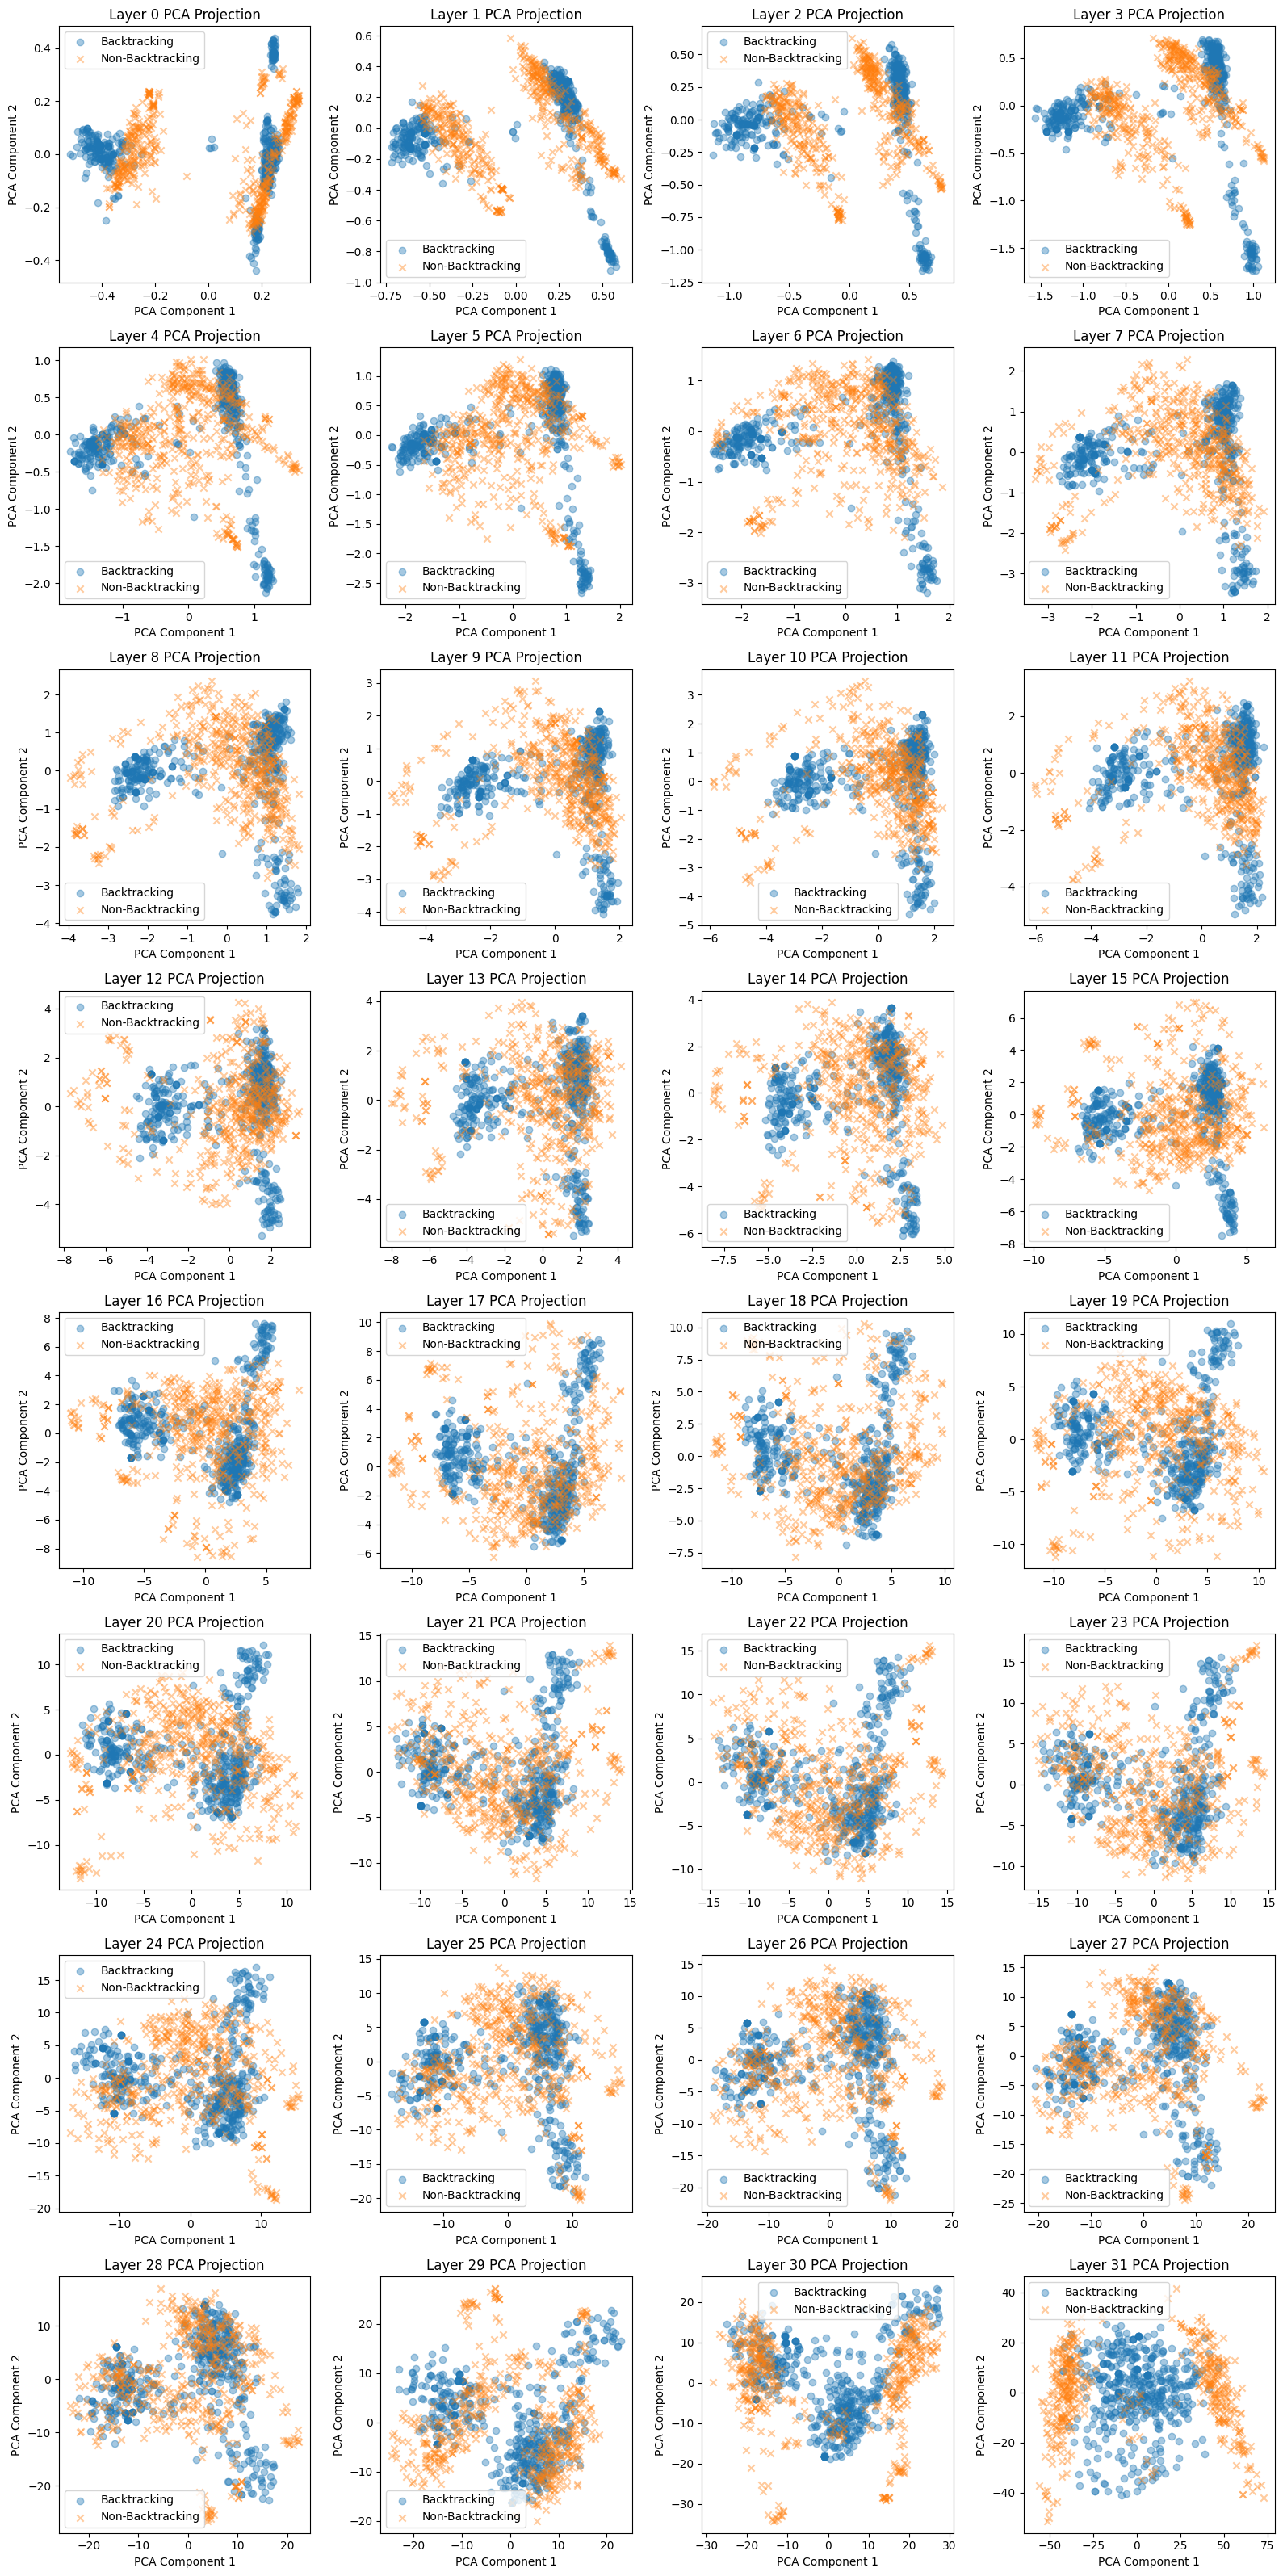

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Placeholder data (Re-create activations for demonstration)
LAYERS = list(range(0, 32))  # Simulate 31 layers
num_samples = 100  # Number of samples per category
feature_dim = 4096  # Feature dimension

# Generate synthetic activations for backtracking and non-backtracking samples
backtracking_activations = relevant_activations["backtracking"]
non_backtracking_activations = relevant_activations["non_backtracking"]

# Determine grid size for plotting
num_cols = 4  # Set 4 columns
num_rows = (len(LAYERS) + num_cols - 1) // num_cols  # Calculate required rows

# Create figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 32))
axes = axes.flatten()  # Flatten for easy iteration

# Perform PCA and plot results per layer
for idx, layer in enumerate(LAYERS):
    ax = axes[idx]

    # Get activations for PCA
    activations_backtracking = backtracking_activations[layer]
    activations_non_backtracking = non_backtracking_activations[layer]

    pca = PCA(n_components=2)
    pca_backtracking = pca.fit_transform(activations_backtracking)
    pca_non_backtracking = pca.fit_transform(activations_non_backtracking)

    # Scatter plot of PCA components
    ax.scatter(pca_backtracking[:, 0], pca_backtracking[:, 1], alpha=0.4, label="Backtracking", marker="o")
    ax.scatter(pca_non_backtracking[:, 0], pca_non_backtracking[:, 1], alpha=0.4, label="Non-Backtracking", marker="x")
    ax.set_title(f"Layer {layer} PCA Projection")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.legend()

# Remove empty subplots if any
for i in range(len(LAYERS), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show
plt.tight_layout()
plt.show()


In [96]:
def collect_relevant_activations(activations_data, tokenizer):
    """
    Collects activations from each layer for backtracking and non-backtracking sentences.
    
    Returns:
        activations_dict = {
            "backtracking": [{layer_1: activations, layer_2: activations, ...}],
            "non_backtracking": [{layer_1: activations, layer_2: activations, ...}]
        }
    """
    activations_dict = {key:{} for key in COT_CUES["is_backtracking"]}
    activations_dict["non_backtracking"] = {}
    print(activations_dict.keys())
    max_non = 1000
    count = 0
    for data in activations_data:
        cue_start = data["cue_start"]
        determining_token_index = data["determining_token_index"]
        cot_cue_value = data["cot_cue_value"]
        top_tokens = data["top_tokens"]
        activations = data["activations"]
        sentence_start = data["sentence_start"]

        # Tokenize the CoT cue value and get its token ID
        cot_cue_token_id = tokenizer(cot_cue_value, add_special_tokens=False)["input_ids"][0]
        # print(cue_start)
        # Extract top token indices and probabilities
        top_token_ids = top_tokens.indices.tolist()
        top_probs = top_tokens.values.tolist()

        # Check if the sentence starts with the cue and token is in top predictions
        if cue_start and cue_start[0][0] == determining_token_index and cot_cue_token_id in top_token_ids:
            cue_index = top_token_ids.index(cot_cue_token_id)  # Get index in top predictions
            cue_probability = top_probs[cue_index]  # Get probability

            # Collect activations for all layers
            layer_activations = {layer: activations[layer][1] for layer in activations}  # Activation at token index 1

            if cue_probability > 0.5:  # High confidence in cue prediction
                for layer, activation in activations.items():
                    if layer not in activations_dict[cot_cue_value]:
                        activations_dict[cot_cue_value][layer] = []
                    activations_dict[cot_cue_value][layer].append(activation[0])  # Activation at token index 1

            # else:
                # print("SKIPPING")
        else:
            if cot_cue_token_id not in top_token_ids or top_probs[ top_token_ids.index(cot_cue_token_id)] < .05:
                count += 1
                if count > max_non:
                    continue
                for layer, activation in activations.items():
                    # print("layer", layer)
                    if layer not in activations_dict["non_backtracking"]:
                        activations_dict["non_backtracking"][layer] = []
                    activations_dict["non_backtracking"][layer].append(activation[0])  # Activation at token index 1

            # else:
                # print("SKIPPING")

    return activations_dict

# Example usage

"""
relevant_activations = {
    "backtracking": {layer_1: [activation_1, activation_2, ...], ...},
    "non_backtracking": {layer_1: [activation_1, activation_2, ...], ...},
    "other_class_1": {layer_1: [activation_1, activation_2, ...], ...},
    "other_class_2": {layer_1: [activation_1, activation_2, ...], ...}
}

"""
relevant_activations = collect_relevant_activations(activations_data, tokenizer)


dict_keys([' Wait', ' No', ' Nope', ' Actually', ' Hold', ' Hang', ' Oops', ' Sorry', 'non_backtracking'])


0

 Wait
 No
 Nope


KeyError: 0

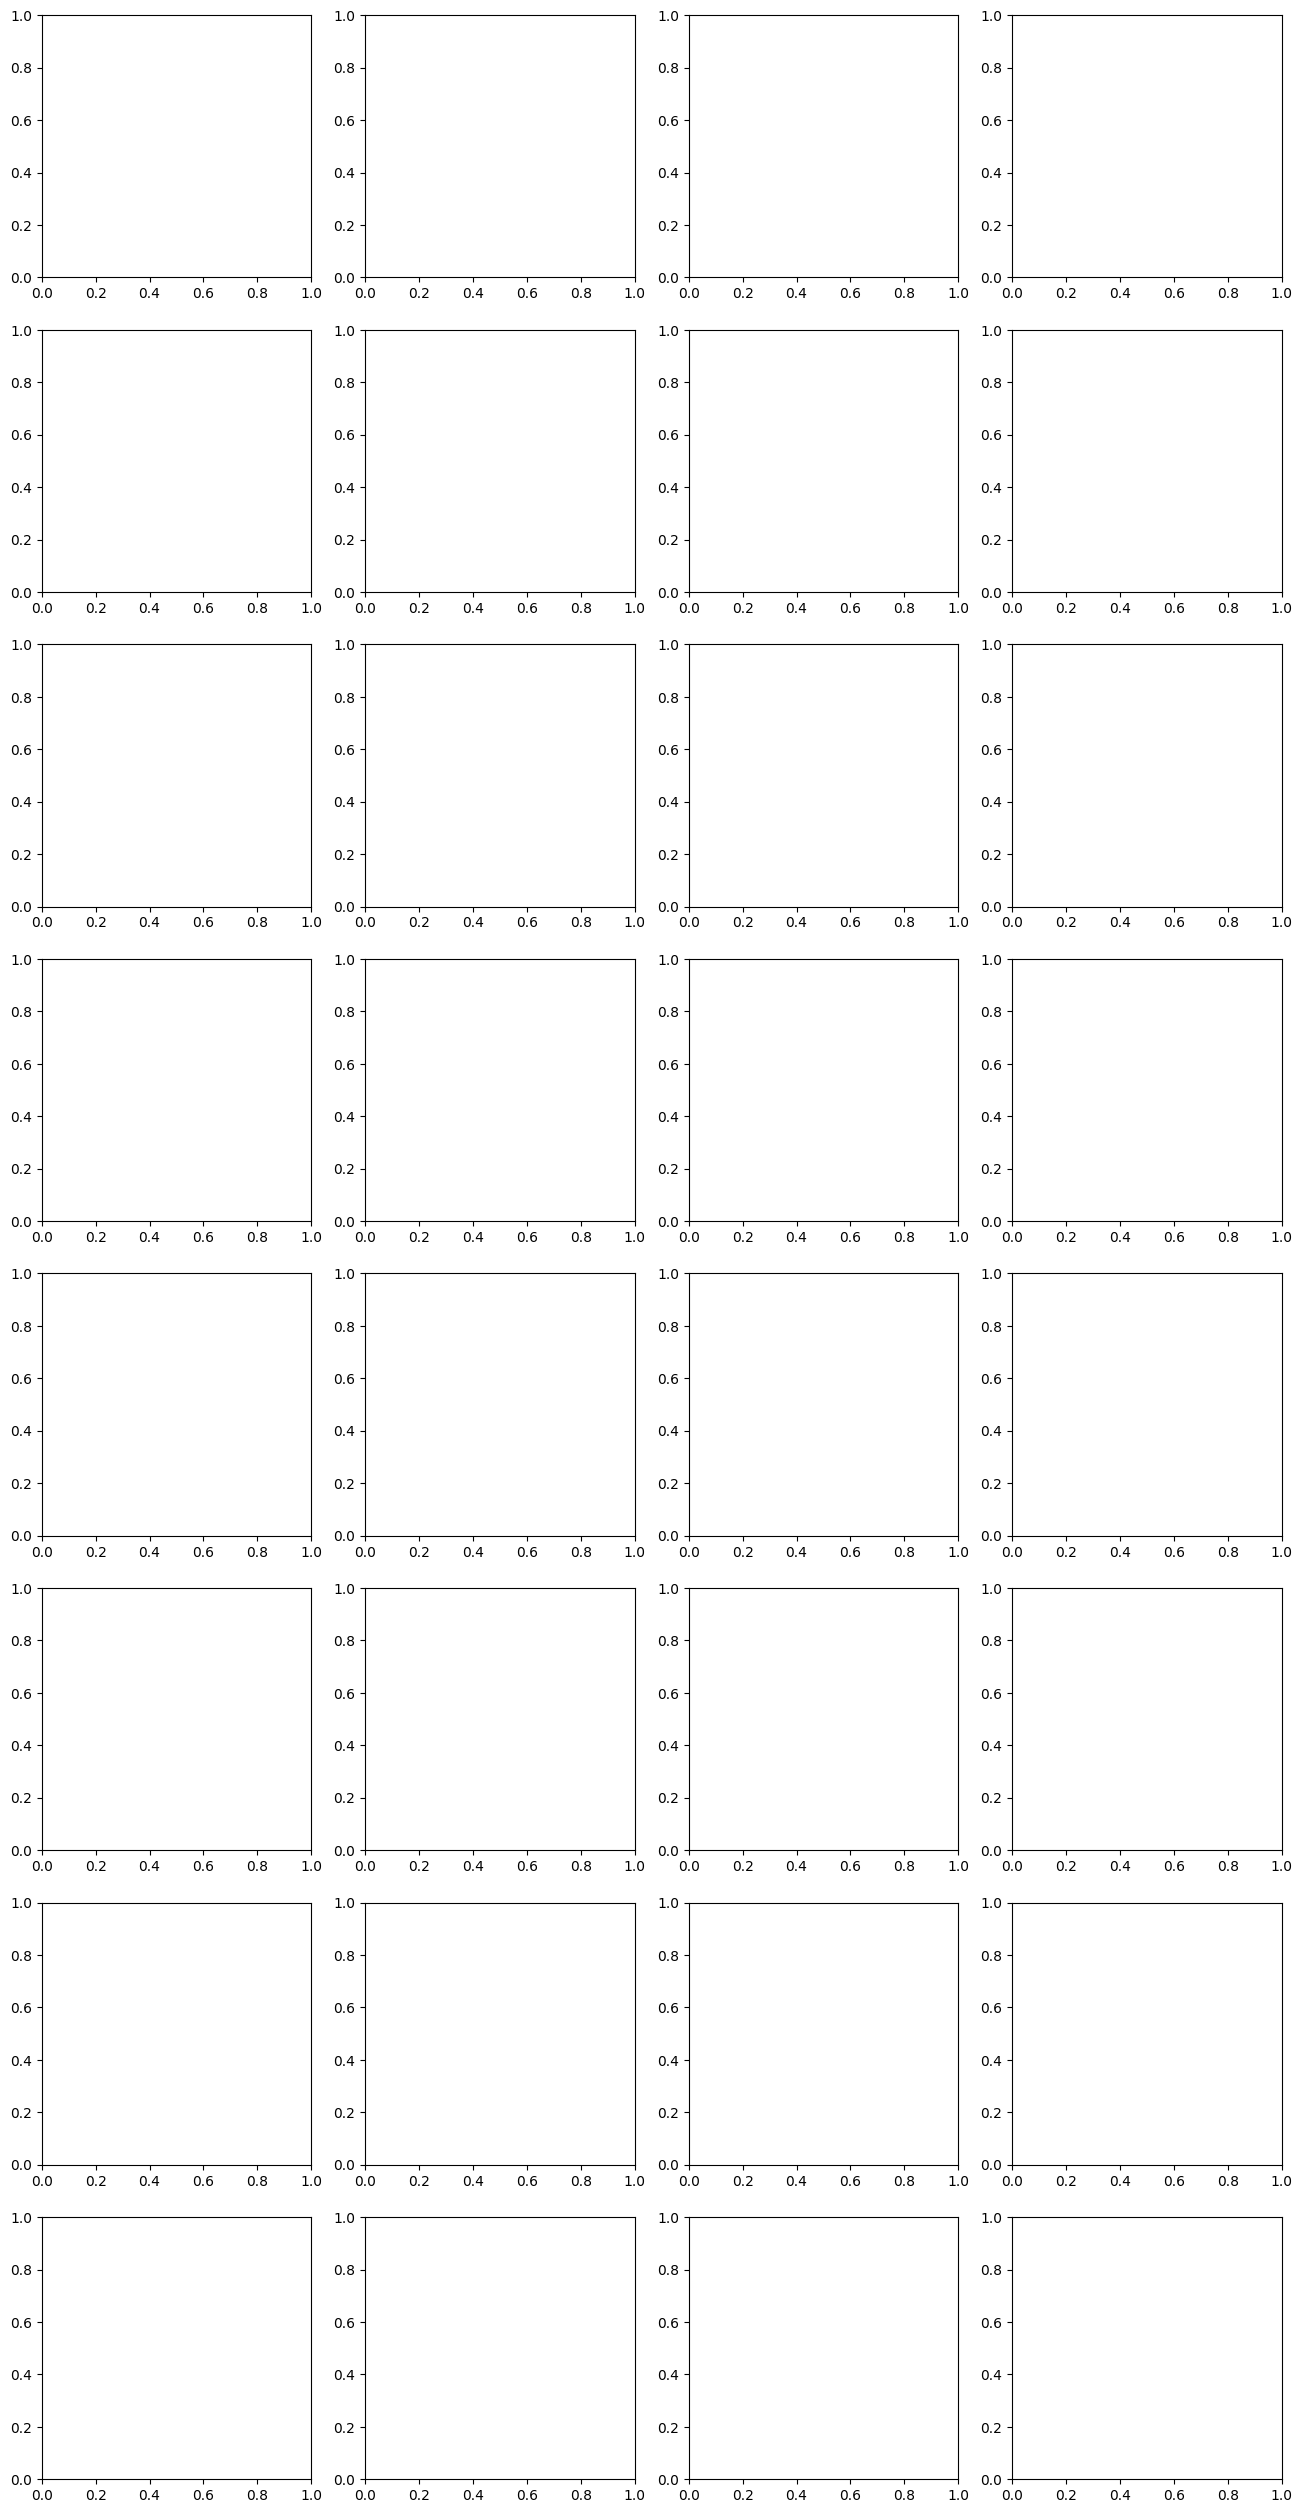

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

def plot_multi_class_pca(relevant_activations, layers, figsize=(16, 32), num_cols=4, fit_separate=False):
    """
    Plot PCA projections for multiple classes across different layers.
    
    Args:
        relevant_activations (dict): Dictionary with class names as keys and layer activations as values
        layers (list): List of layer indices to plot
        figsize (tuple): Figure size (width, height)
        num_cols (int): Number of columns in the subplot grid
        fit_separate (bool): If True, fit PCA separately for each class. If False, fit on all data combined.
    """
    # Get class names
    classes = list(relevant_activations.keys())
    
    # Define a color cycle (with more colors than default matplotlib)
    colors = list(mcolors.TABLEAU_COLORS) + list(mcolors.CSS4_COLORS)[:len(classes)]
    
    # Define a variety of markers
    markers = ['o', 'x', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+']
    
    # Determine grid size for plotting
    num_rows = (len(layers) + num_cols - 1) // num_cols
    
    # Create figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten() if num_rows * num_cols > 1 else [axes]  # Flatten for easy iteration
    
    # Perform PCA and plot results per layer
    for idx, layer in enumerate(layers):
        ax = axes[idx]
        
        if fit_separate:
            # Perform PCA separately for each class
            for i, (class_name, activations_dict) in enumerate(relevant_activations.items()):
                print(class_name)
                activations = activations_dict[layer]
                pca = PCA(n_components=2)
                pca_result = pca.fit_transform(activations)
                
                # Use modulo to cycle through colors and markers if we have more classes than options
                color = colors[i % len(colors)]
                marker = markers[i % len(markers)]
                
                ax.scatter(
                    pca_result[:, 0], pca_result[:, 1], 
                    alpha=0.5, label=class_name,
                    marker=marker, color=color, s=50
                )
        else:
            # Combine all data for a single PCA fit
            all_data = []
            class_indices = []
            
            for class_idx, (class_name, activations_dict) in enumerate(relevant_activations.items()):
                print(class_name)
                activations = activations_dict[layer]
                all_data.append(activations)
                class_indices.extend([class_idx] * len(activations))
            
            # Combine data and fit PCA
            combined_data = np.vstack(all_data)
            class_indices = np.array(class_indices)
            
            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(combined_data)
            
            # Scatter plot for each class
            for i, class_name in enumerate(classes):
                mask = (class_indices == i)
                color = colors[i % len(colors)]
                marker = markers[i % len(markers)]
                
                ax.scatter(
                    pca_result[mask, 0], pca_result[mask, 1], 
                    alpha=0.5, label=class_name,
                    marker=marker, color=color, s=50
                )
        
        ax.set_title(f"Layer {layer} PCA Projection")
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        
        # Add grid for better readability
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add a small margin around points
        ax.autoscale(enable=True, tight=False)
        
    # Create a single legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
               ncol=min(5, len(classes)), frameon=True, fancybox=True, shadow=True)
    
    # Remove empty subplots if any
    for i in range(len(layers), len(axes)):
        fig.delaxes(axes[i])
    
    # Adjust layout and return figure
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Make room for the legend
    
    return fig

# Example usage:
if __name__ == "__main__":
    # Placeholder data (Re-create activations for demonstration)
    LAYERS = list(range(0, 32))

    
    # Plot using the global PCA fit
    fig = plot_multi_class_pca(relevant_activations, LAYERS[:], fit_separate=False)
    plt.savefig('multi_class_pca_global.png', dpi=300, bbox_inches='tight')
    
    # Plot using separate PCA fits per class
    fig = plot_multi_class_pca(relevant_activations, LAYERS[:], fit_separate=True)
    plt.savefig('multi_class_pca_separate.png', dpi=300, bbox_inches='tight')
    
    plt.show()

## Debugging Functions

In [31]:
def get_all_possible_token_ids(tokenizer, text, max_newlines=2, max_spaces=2):
    """
    Generates all possible token IDs for a given string, allowing up to max_newlines and max_spaces before it.
    
    Args:
        tokenizer: The tokenizer instance.
        text (str): The base string (case-sensitive).
        max_newlines (int): Max number of \n characters to prepend.
        max_spaces (int): Max number of spaces to prepend.

    Returns:
        dict: A dictionary where the keys are the variations and values are token ID lists.
    """
    variations = set()
    
    # Generate all variations with leading spaces and newlines
    for num_newlines in range(max_newlines + 1):  # Allow up to `max_newlines`
        for num_spaces in range(max_spaces + 1):  # Allow up to `max_spaces`
            prefix = ("\n" * num_newlines) + (" " * num_spaces)
            variations.add(prefix + text)

    token_variants = {}

    # Tokenize and store token IDs for each variant
    for variant in variations:
        encoding = tokenizer(variant, add_special_tokens=False)
        token_ids = encoding["input_ids"]
        tokens = tokenizer.convert_ids_to_tokens(token_ids)

        token_variants[variant] = {
            "token_ids": token_ids,
            "tokens": tokens
        }

    return token_variants

# Load tokenizer
# Test with any string
test_string = "Wait"
token_variants = get_all_possible_token_ids(tokenizer, test_string)

# Print results
for variant, data in token_variants.items():
    print(f"String: {repr(variant)}")
    print(f"Token IDs: {data['token_ids']}")
    print(f"Tokens: {data['tokens']}")
    print("-" * 50)


String: 'Wait'
Token IDs: [14524]
Tokens: ['Wait']
--------------------------------------------------
String: '\nWait'
Token IDs: [198, 14524]
Tokens: ['Ċ', 'Wait']
--------------------------------------------------
String: '  Wait'
Token IDs: [220, 14144]
Tokens: ['Ġ', 'ĠWait']
--------------------------------------------------
String: ' Wait'
Token IDs: [14144]
Tokens: ['ĠWait']
--------------------------------------------------
String: '\n Wait'
Token IDs: [198, 14144]
Tokens: ['Ċ', 'ĠWait']
--------------------------------------------------
String: '\n\n  Wait'
Token IDs: [271, 220, 14144]
Tokens: ['ĊĊ', 'Ġ', 'ĠWait']
--------------------------------------------------
String: '\n\nWait'
Token IDs: [271, 14524]
Tokens: ['ĊĊ', 'Wait']
--------------------------------------------------
String: '\n  Wait'
Token IDs: [198, 220, 14144]
Tokens: ['Ċ', 'Ġ', 'ĠWait']
--------------------------------------------------
String: '\n\n Wait'
Token IDs: [271, 14144]
Tokens: ['ĊĊ', 'ĠWait']
-------

Saved as Pickle successfully!


In [37]:
print("num samples collected: ", len(activations_data))

num samples collected:  8031


In [38]:
uuids = {entry["uuid"] for entry in activations_data}  # Use set for uniqueness
len(uuids)

51

In [39]:
"""
activations_data.append({
            "uuid": sample["uuid"],
            "full_message": message,
            "sentence": sentence,
            "is_backtracking": is_backtracking,
            "cue_probability": None,  # Compute later
            "char_offset": message.find(sentence),  # Char offset in full message
            "cue_indices": info["cue_indices"],
            "sentence_start_index":  info["sentence_start_index"],
            "activations": sentence_activations,
        })"""
norms = []
for a in range(1):
    for layer in activations_data[a]["activations"]:
        act_l = activations_data[a]["activations"][layer]
        norm = np.linalg.norm(act_l)
        if norm > 600:
            print(activations_data[a]["sentence"])
            print(activations_data[a]["is_backtracking"])

            print(layer)
            
        norms.append(norm)
        
        
min(norms), max(norms)

(1.2450383, 92.368065)

In [40]:
backtracking_activations_by_layer = {layer: [] for layer in range(1, 33)}
non_backtracking_activations_by_layer ={layer: [] for layer in range(1, 33)}
back_count = 0
non_back_count = 0
for a in range(len(activations_data)):
    sample_a_data = activations_data[a]
    is_backtracking =  activations_data[a]["is_backtracking"]
    activations = activations_data[a]["activations"]
    if is_backtracking:
        print("is_backtracking", is_backtracking)
        back_count += 1
    else:
        non_back_count += 1
    if is_backtracking and back_count > 400:
        continue
    if not is_backtracking and non_back_count >= 400:
        continue

    # print(activations[1].shape)
    # Add activations to the appropriate list for each layer
    for layer in activations:
        # Choose the right dictionary based on backtracking status
        if is_backtracking:
            # target_dict = backtracking_activations_by_layer if is_backtracking else non_backtracking_activations_by_layer
            # print("target_dict", target_dict)
            # Add the activation(s) to the appropriate layer
            # Handle both single activations and arrays of activations
            # print(isinstance(activations[layer], np.ndarray))
            if len(activations[layer].shape) > 1:
                # print("activations[layer][0]", activations[layer][0])
                backtracking_activations_by_layer[layer].append(activations[layer][0])
                # # Multiple activations (e.g., for multiple cue indices)
                # for idx in range(activations[layer].shape[0]):
                #     # print(idx)
                #     # print(activations[layer][idx])
                #     backtracking_activations_by_layer[layer].append(activations[layer][idx])
                #     # print(backtracking_activations_by_layer.keys())
            else:
                # Single activation
                backtracking_activations_by_layer[layer].append(activations[layer])
            # break
        else:
             non_backtracking_activations_by_layer[layer].append(activations[layer])

# Convert lists to numpy arrays for each layer
for layer in range(1, 33):
    if backtracking_activations_by_layer[layer]:
        backtracking_activations_by_layer[layer] = np.vstack(backtracking_activations_by_layer[layer])
    if non_backtracking_activations_by_layer[layer]:
        non_backtracking_activations_by_layer[layer] = np.vstack(non_backtracking_activations_by_layer[layer])


is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracking True
is_backtracki

In [41]:
len(backtracking_activations_by_layer[1]), len(non_backtracking_activations_by_layer[1])

(67, 399)

In [42]:
import numpy as np

def aggregate_activations(cue_activations):
    """
    Given activations from multiple layers, compute the mean activation per layer.
    
    Args:
        cue_activations (dict): Dictionary where keys are layer indices and values are 
                                numpy arrays of shape (num_tokens, feature_dim).

    Returns:
        dict: Dictionary with one 4096-dimensional vector per layer (mean activation).
    """
    mean_activations = {
        layer: np.mean(activations, axis=0)  # Average over token activations
        for layer, activations in cue_activations.items()
    }
    return mean_activations


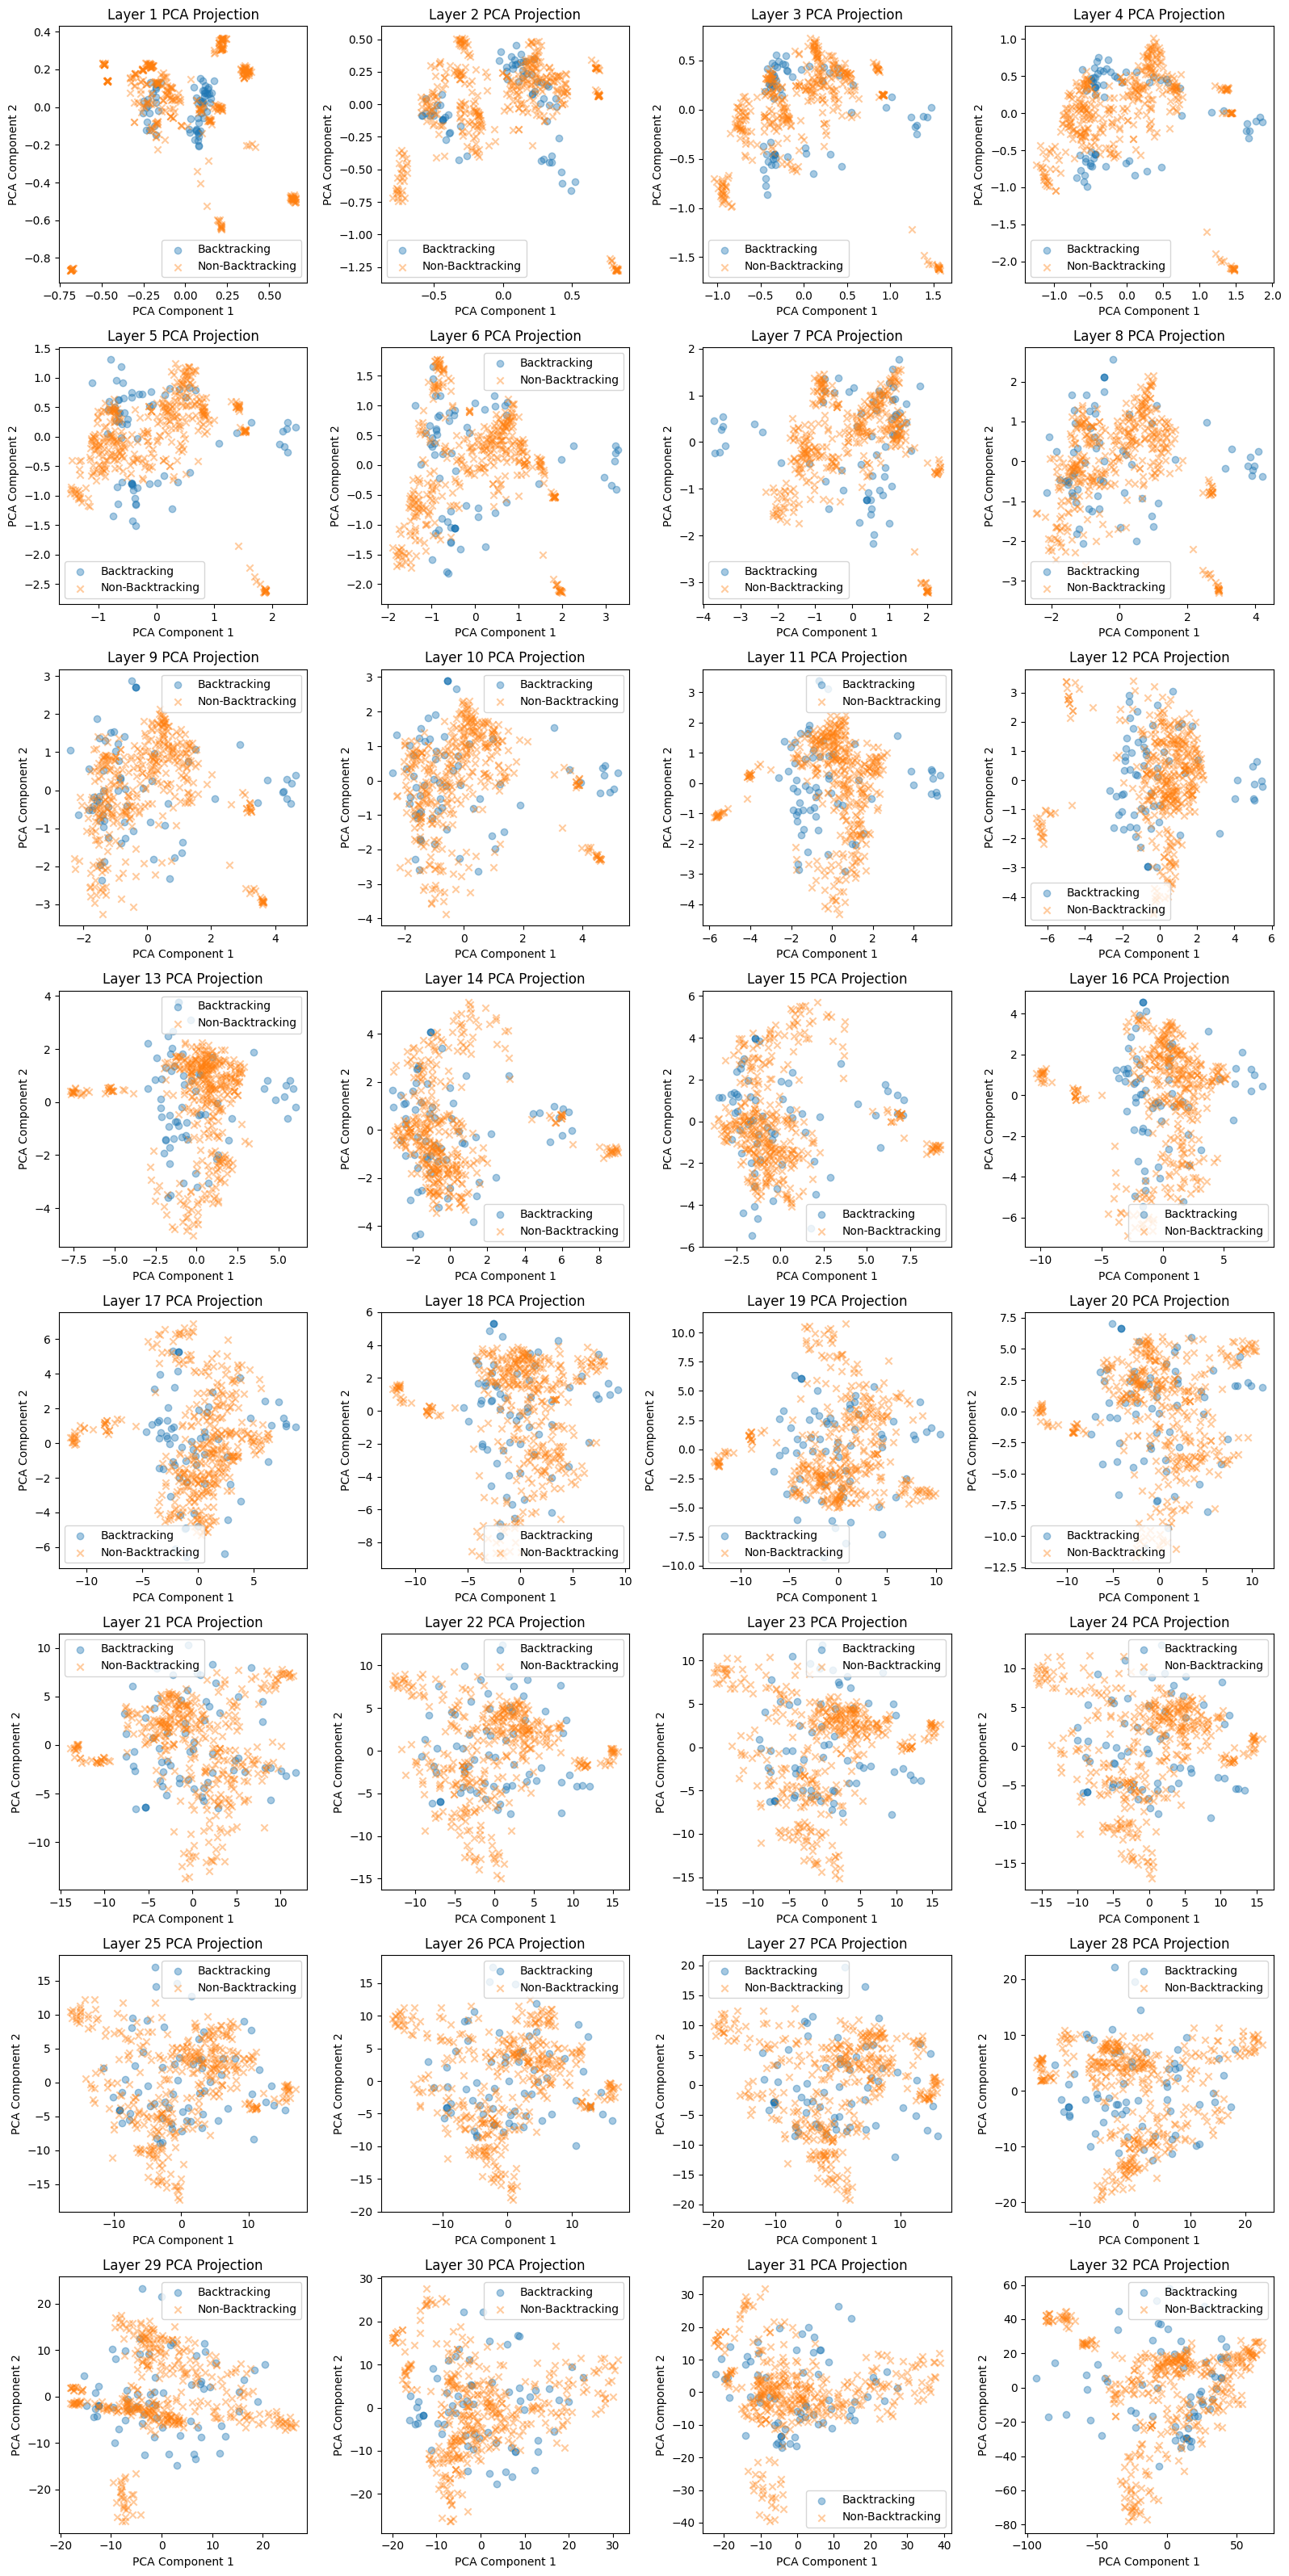

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Placeholder data (Re-create activations for demonstration)
LAYERS = list(range(1, 33))  # Simulate 31 layers
num_samples = 100  # Number of samples per category
feature_dim = 4096  # Feature dimension

# Generate synthetic activations for backtracking and non-backtracking samples
backtracking_activations = backtracking_activations_by_layer
non_backtracking_activations = non_backtracking_activations_by_layer

# Determine grid size for plotting
num_cols = 4  # Set 4 columns
num_rows = (len(LAYERS) + num_cols - 1) // num_cols  # Calculate required rows

# Create figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 32))
axes = axes.flatten()  # Flatten for easy iteration

# Perform PCA and plot results per layer
for idx, layer in enumerate(LAYERS):
    ax = axes[idx]

    # Get activations for PCA
    activations_backtracking = backtracking_activations[layer]
    activations_non_backtracking = non_backtracking_activations[layer]

    pca = PCA(n_components=2)
    pca_backtracking = pca.fit_transform(activations_backtracking)
    pca_non_backtracking = pca.fit_transform(activations_non_backtracking)

    # Scatter plot of PCA components
    ax.scatter(pca_backtracking[:, 0], pca_backtracking[:, 1], alpha=0.4, label="Backtracking", marker="o")
    ax.scatter(pca_non_backtracking[:, 0], pca_non_backtracking[:, 1], alpha=0.4, label="Non-Backtracking", marker="x")
    ax.set_title(f"Layer {layer} PCA Projection")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.legend()

# Remove empty subplots if any
for i in range(len(LAYERS), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show
plt.tight_layout()
plt.show()
